In [1]:
import os
import re
from datetime import time, timedelta
from datetime import datetime
from random import randrange
import gzip
import json
import pandas as pd
import collections
import pytz as tz
import sys

sys.path.append("/Users/amk/S2DS/locals/Aug22_EPRI_Red")
import helpers.zeek_logs_parser as zeek
from helpers.zeek_logs_parser import TimeInterval,Log

In [2]:
DATA_PATH=os.path.join("..","data","raw","Zeek_Sensor_Logs")
PATH_1=os.path.join(DATA_PATH,"zeek-1_101","2022-07-20")
PATH_2=os.path.join(DATA_PATH,"zeek-2_102","2022-07-20")
#collect logs
logs1=zeek.read_log_names(PATH_1)
logs2=zeek.read_log_names(PATH_2)

In [4]:
#different types of logs, how many of them are and total size (bytes)
log_types={}
for log in logs1:
    if log.kind not in log_types.keys():
        log_types[log.kind]=[1,0]
    else:
        log_types[log.kind]=[log_types[log.kind][0]+1,log_types[log.kind][0]+os.stat(log.file).st_size]

log1_types=collections.OrderedDict(sorted(log_types.items(), key=lambda item: item[1][0],reverse=True))
log_types={}
for log in logs2:
    if log.kind not in log_types.keys():
        log_types[log.kind]=[1,0]
    else:
        log_types[log.kind]=[log_types[log.kind][0]+1,log_types[log.kind][0]+os.stat(log.file).st_size]      
log2_types=collections.OrderedDict(sorted(log_types.items(), key=lambda item: item[1][0],reverse=True))

keys=list(log1_types.keys())+list(set(log2_types.keys())-set(log1_types.keys()) )
log1_types_ext=log1_types.copy()
log2_types_ext=log2_types.copy()
print("kind of log".rjust(20),"zeek1".rjust(20),"zeek2".rjust(25))
print("".rjust(20),"number of logs, size".rjust(20),"number of logs, size".rjust(25))
for key in keys:
    if log1_types_ext.get(key) is None:
        log1_types_ext[key]=''
    if log2_types_ext.get(key) is None:
        log2_types_ext[key]=''
    
    print(key.rjust(20),(str(log1_types_ext[key])).rjust(20),(str(log2_types_ext[key])).rjust(25))

         kind of log                zeek1                     zeek2
                     number of logs, size      number of logs, size
       ecat_arp_info           [179, 515]               [24, 37993]
        capture_loss           [138, 247]                 [24, 186]
                 cip         [109, 10074]                          
                enip          [71, 23769]                          
               stats            [61, 298]                [24, 1036]
              modbus         [51, 108005]                          
        conn-summary           [41, 4922]                [24, 1201]
                conn            [41, 250]               [24, 71125]
              cip_io       [25, 10574377]                          
              notice            [23, 204]                 [24, 465]
      loaded_scripts            [5, 3030]                          
       packet_filter             [5, 104]                          
              stdout             [4, 111]       

In [5]:
START_TIME=1658289600
def accumulate_events(log,timeseries):
    # skip summary logs
    if re.match(r".*-summary|stdout*|loaded_scripts*|stderr*", log.kind):
        return
    else:
        #print(log.kind)
        with gzip.open(log.file, "r") as f:
            for line in f:
                time =int(line[6:16].decode())-START_TIME
                timeseries[log.kind][time//10]+=1
            return

In [13]:
#prepare timeseries to extract info from logs
ignore=["conn-summary","stdout","loaded_scripts","stderr"]
for key in ignore:
    log1_types.pop(key,None)
    log2_types.pop(key,None)
timeseries1={ kind : [0 for i in range(8640)] for kind in log1_types.keys()}
timeseries1["datetime"]= [logs1[0].t_interval[0] + i*timedelta(0,10) for i in range(8640)] 
timeseries2={ kind : [0 for i in range(8640)] for kind in log2_types.keys()}
timeseries2["datetime"]= [logs2[0].t_interval[0] + i*timedelta(0,10) for i in range(8640)] 

In [14]:
#extract info and store it in timeseries1 and timseries2
for log in logs1:
    accumulate_events(log,timeseries1)
for log in logs2:
    accumulate_events(log,timeseries2)

In [21]:
df1=pd.DataFrame.from_dict(timeseries1)
df1.set_index("datetime")
df2=pd.DataFrame.from_dict(timeseries2)
df2.set_index("datetime")
_=_

In [42]:
df1.to_csv("timeseries_zeek_1.csv")
df2.to_csv("timeseries_zeek_2.csv")

In [23]:
#Some plots
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
df1.describe()

,ecat_arp_info,capture_loss,cip,enip,stats,modbus,conn,cip_io,notice,packet_filter,known_services,reporter,modbus_detailed,known_hosts
count,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000
mean,0.308796,0.015972,18.035069,27.395139,0.007060,173.527315,0.020370,4643.680324,0.002894,0.000579,0.001157,0.000926,15.699421,0.000347
std,0.965676,0.146651,29.207118,58.776077,0.085104,446.445962,0.419793,19283.597920,0.057866,0.024051,0.056919,0.043026,185.000980,0.032275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20.000000,2.000000,376.000000,356.000000,2.000000,1335.000000,18.000000,164000.000000,2.000000,1.000000,4.000000,2.000000,2668.000000,3.000000


In [25]:
df2.describe()

,smb_mapping,conn,ecat_arp_info,stats,weird_stats,smb_cmd,ntp,notice,weird,x509,...,files,http,ntlm,dns,capture_loss,software,kerberos,ocsp,dhcp,ssh
count,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,...,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.00000,8640.000000,8640.000000
mean,0.012269,5.913889,12.104861,0.033333,0.068634,0.247685,8.769329,0.013657,0.094560,0.019560,...,0.105787,0.070255,0.007523,4.955903,0.011111,0.006713,0.007639,0.00463,0.001273,0.000231
std,0.110088,11.239132,4.457111,0.179516,0.661677,4.108551,0.547043,0.116071,0.543484,0.265223,...,0.899081,0.525356,0.086414,11.455194,0.104828,0.122487,0.155724,0.11678,0.035661,0.015214
min,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,4.000000,9.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,5.000000,12.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,6.000000,15.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,466.000000,35.000000,1.000000,9.000000,188.000000,11.000000,1.000000,11.000000,11.000000,...,39.000000,20.000000,1.000000,472.000000,1.000000,4.000000,7.000000,7.00000,1.000000,1.000000


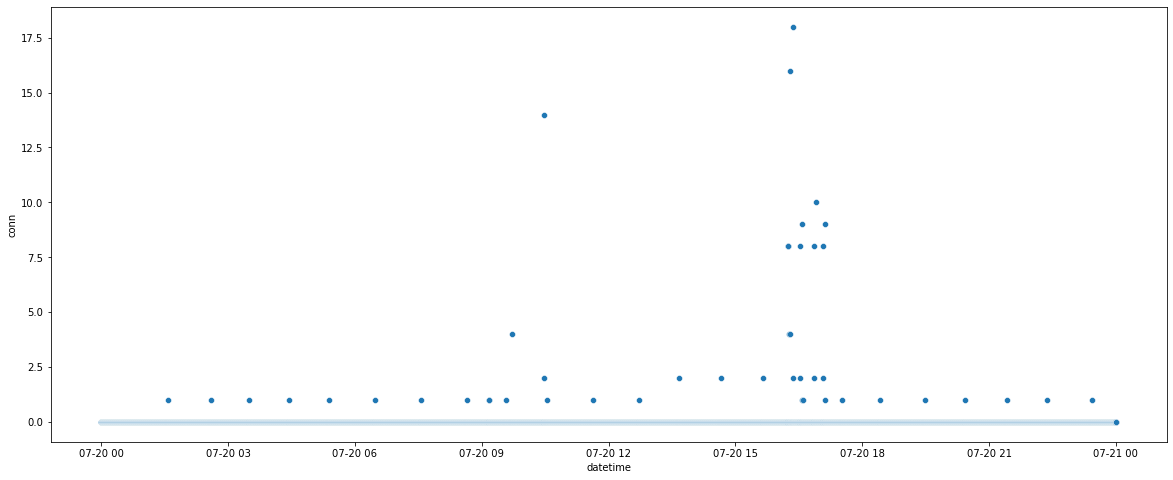

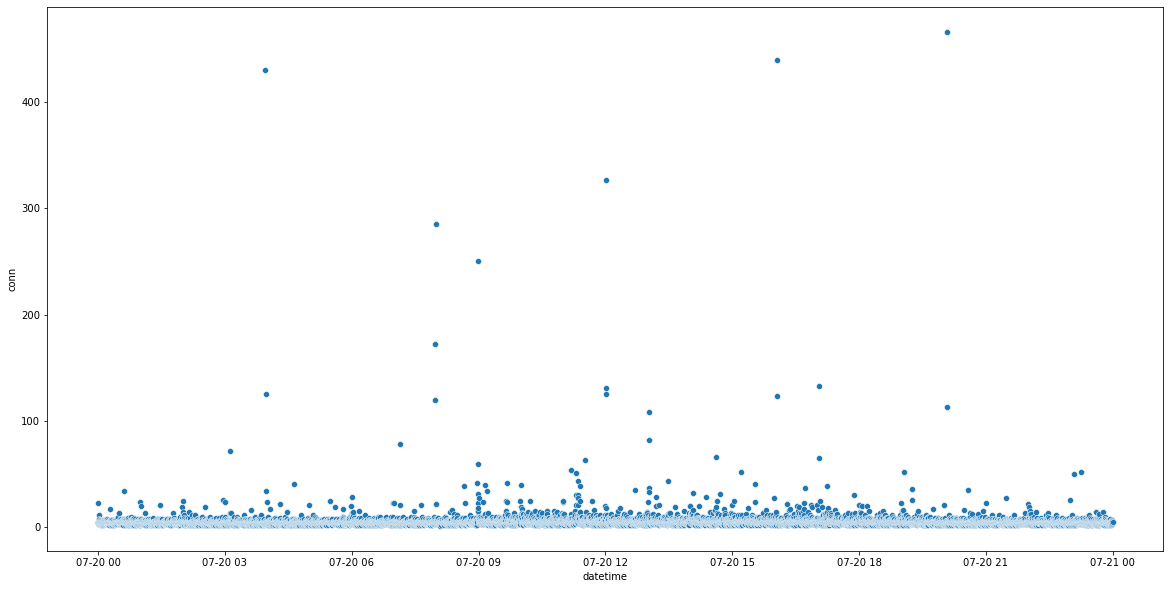

In [46]:
#plots for conn
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.scatterplot(data=df1,x="datetime",y="conn")
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=df2,x="datetime",y="conn")

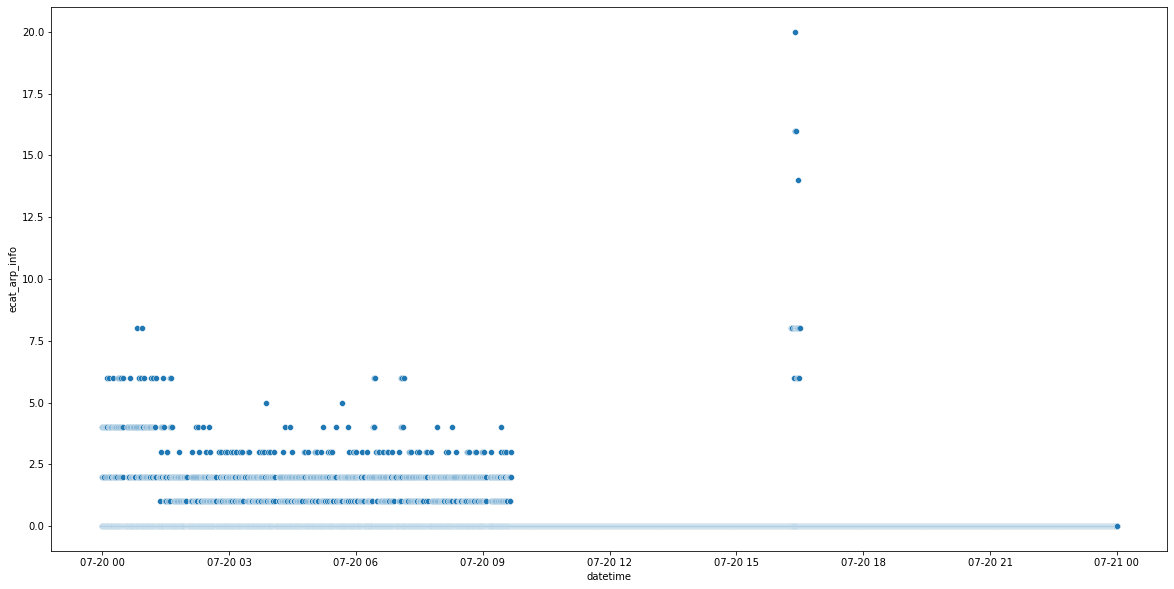

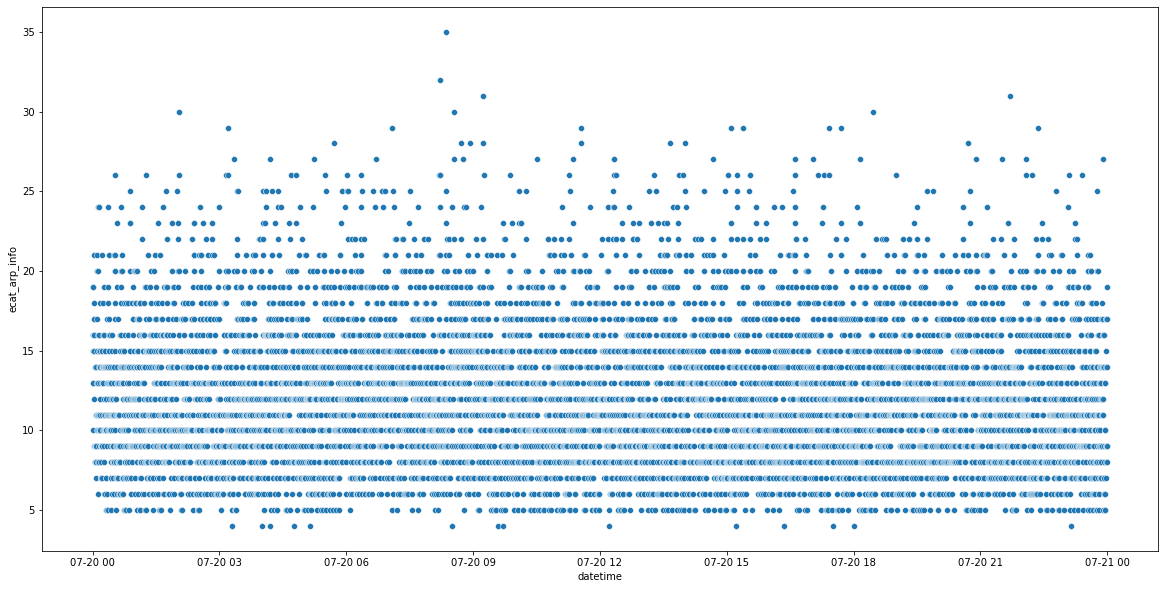

In [47]:
#plots for ecat_arp_info
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=df1,x="datetime",y="ecat_arp_info")
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=df2,x="datetime",y="ecat_arp_info")

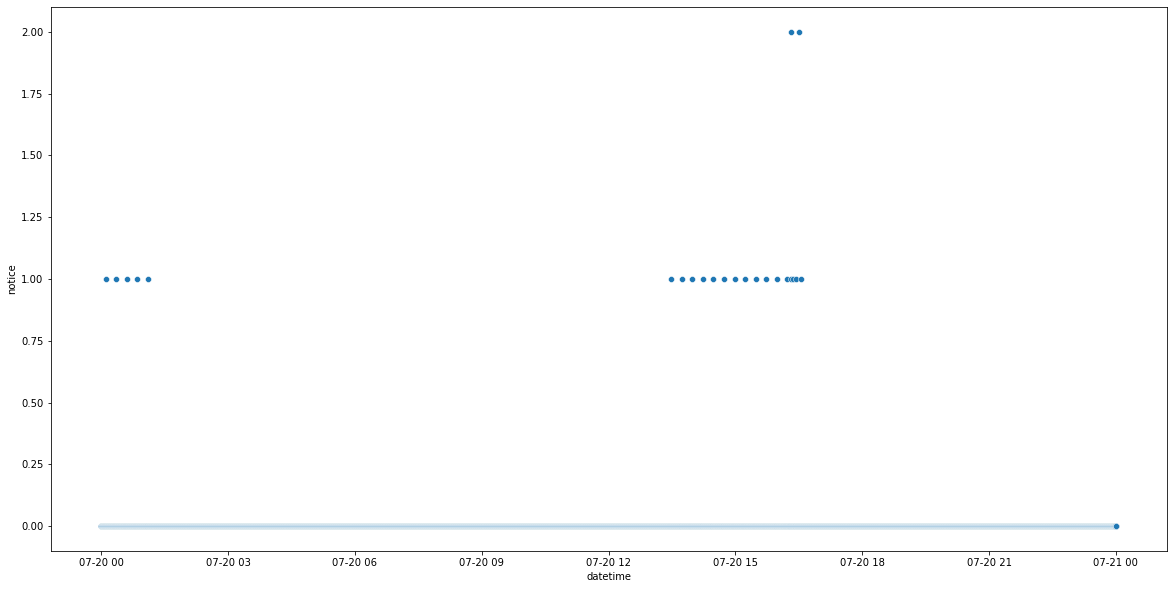

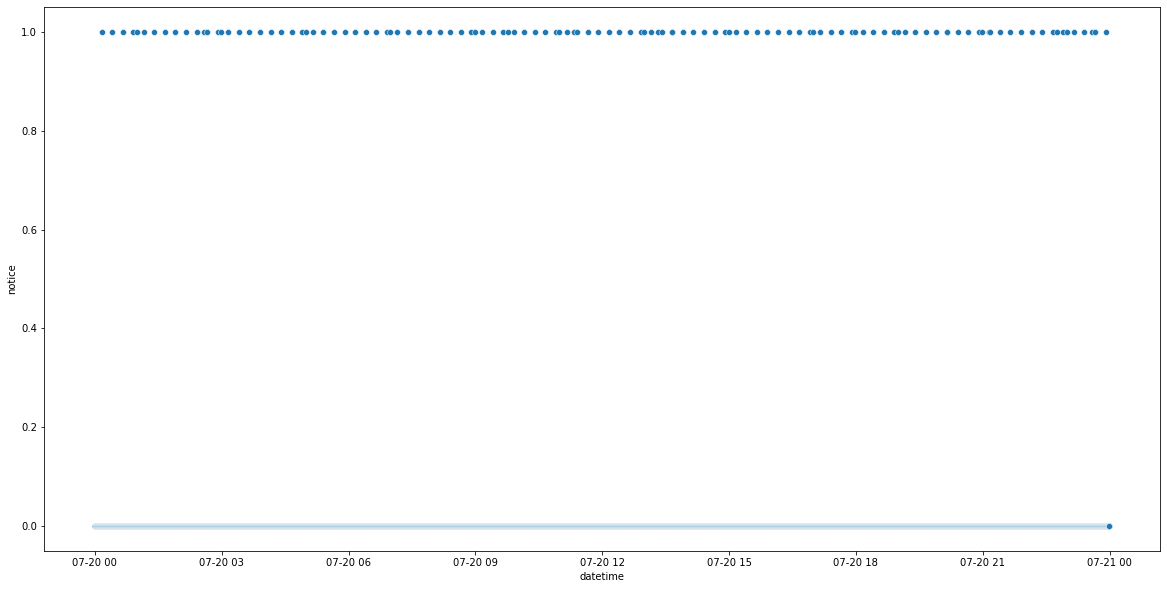

In [48]:
#plots for notice
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=df1,x="datetime",y="notice")
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=df2,x="datetime",y="notice")

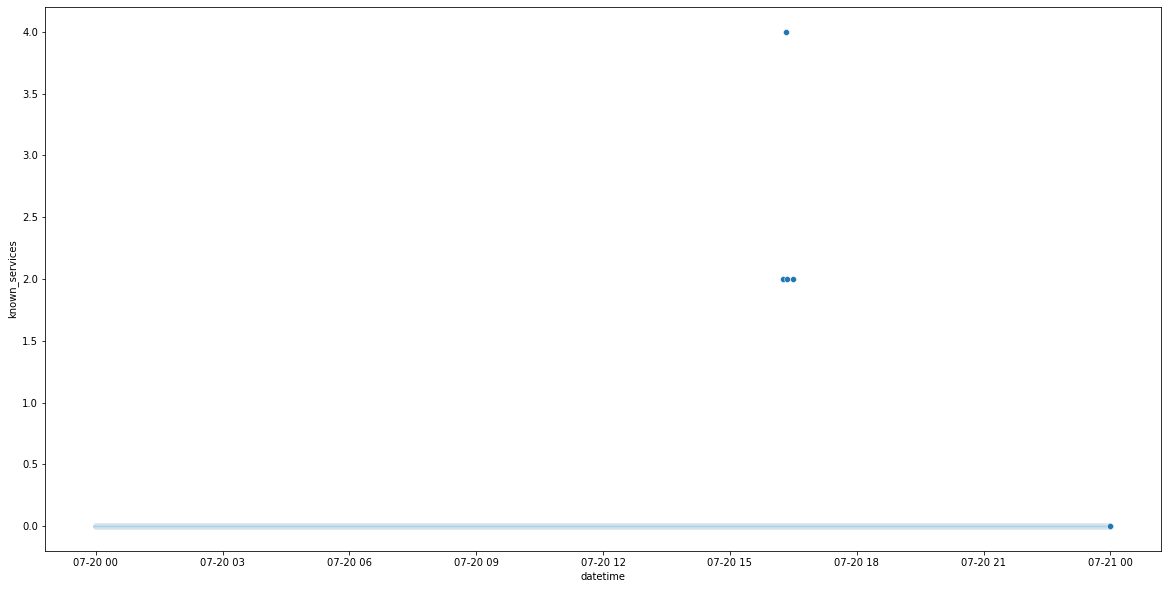

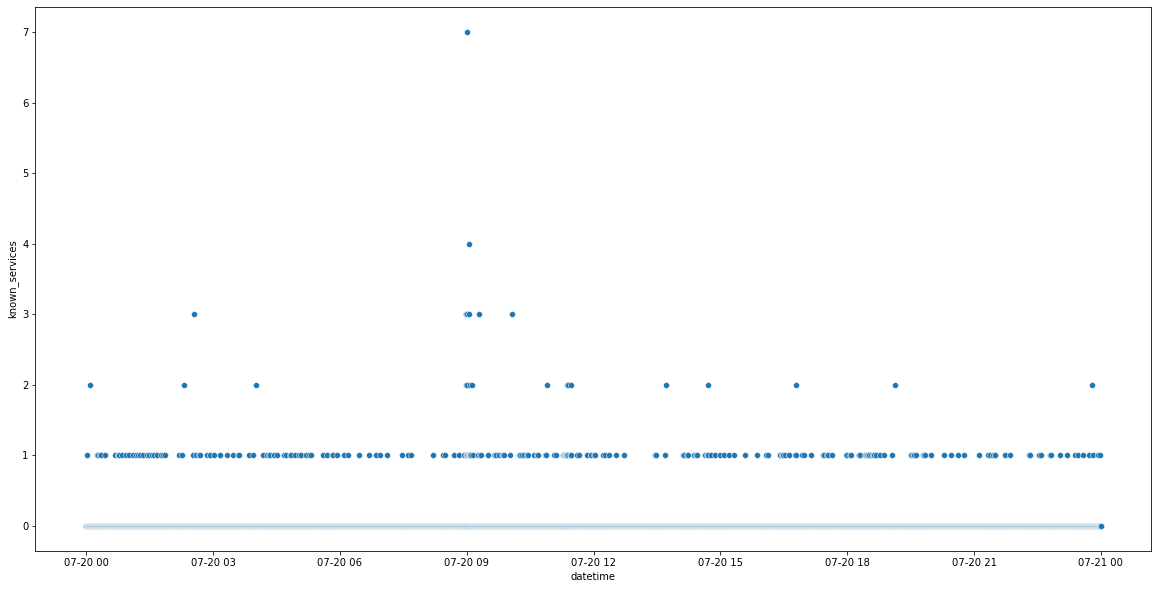

In [52]:
#plots for notice
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=df1,x="datetime",y="known_services")
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=df2,x="datetime",y="known_services")